# Ising Model for Ferromagnets

## Base Installs and Imports

In [ ]:
!pip install -q scienceplots
!sudo apt -qq install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super


In [2]:
import numpy as np
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

import numba
from tqdm.auto import tqdm
from scipy.ndimage import convolve, generate_binary_structure

## Theory

Given a system is in thermal equilibrium with a temperature bath, the probability $p_\mu$ of the system being in the state $\mu$ with energy $E_\mu$ is $$p_\mu = \frac{1}{Z} e^{-\beta E_\mu}$$

where $Z = \sum_\mu e^{-\beta E_\mu}$ is the **partition function**. At equilibrium: $$\sum_\mu p_\mu P(\mu → \nu) = \sum_\nu p_\nu P(\nu → \mu)$$

where $P(\mu → \nu)$ is the probability of going from state $\mu$ to $\nu$. Numerically, it is difficult to enforce, but we can ensure it by setting the **detailed balance condition** $$p_\mu P(\mu → \nu) = p_\nu P(\nu → \mu)$$

**The Ising Model**

The total energy of the system in a state $\nu$ is $$E_\mu = -\sum_{<i, j>} J \sigma_i \sigma_j$$ where $\sum_{<i, j>}$ denotes the sum over the nearest neighbours for all points in the lattice, $\sigma_i$ is the spin of a single particle in the lattice (-1 or 1). Now, satisfying the detailed balance: $$\frac{P(\mu → \nu)}{P(\nu → \mu)} = \frac{p_\nu }{p_\mu} = e^{-\beta(E_\nu - E_\mu)}$$

**The Metropolis Algorithm**

We want to find the equilibrium state $\mu$ in the magnet at a temperature $\beta$ (i.e., how many $\sigma_i$ are +1 and how many are -1). We start with random lattice spins, and make it dance around using the above balance equation until the system reaches equilibrium.

- Let the current state be $\mu$.
- Pick a random particle on the lattice and flip its spin and call this new state of the lattice as $\nu$. We want to find the probability $P(\mu → \nu)$ that we accept this new state.

    - If $E_\nu > E_\mu$ then set $P(\nu → \mu) = 1$ and thus by detailed balance, $\frac{P(\mu → \nu)}{P(\nu → \mu)} = e^{-\beta(E_\nu - E_\mu)}$.
    - If $E_\nu > E_\mu$ then set  $P(\mu → \nu) = 1$ which still satisfies detailed balance.

- Change to state $\nu$ with the above probabilities.
- Go back to Step 1 and continue to the next steps. Repeat till an equilibrium state is reached.

$\therefore$ the only thing remaining to be evaluated is $-\beta(E_\nu - E_\mu) = -\beta J \sum_{k=1}^{4} \sigma_i \sigma_k$ where $\sigma_i$ is the spin being flipped and $\sigma_k$ are the 4 nearest neighbours (due to the system being in a 2D plane), with lesser neighbours at the boundaries.

## Code

In [4]:
# 50 by 50 grid
N = 50
# RNG for reproducibility
rng = np.random.default_rng(seed=100)

Initiate a random grid of spins

In [5]:
from numpy.typing import NDArray
from numpy.random._generator import Generator

def rand_init_grid(
    shape:tuple[int, int],
    threshold:float,
    rng:Generator
) -> NDArray:

    rand_init = rng.random(shape)
    lattice = np.zeros(shape)
    lattice[rand_init >= threshold] = 1
    lattice[rand_init < threshold] = -1
    return lattice

lattice_p = rand_init_grid((N,N), 0.75, rng)
lattice_n = rand_init_grid((N,N), 0.25, rng)

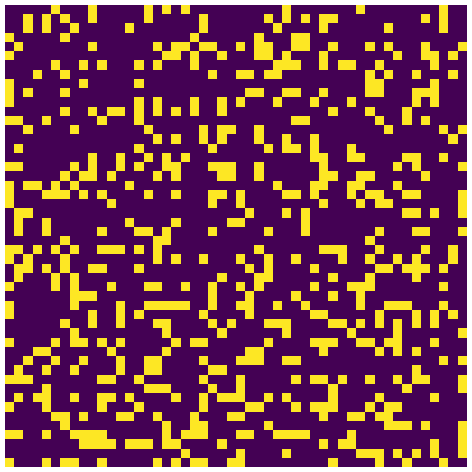

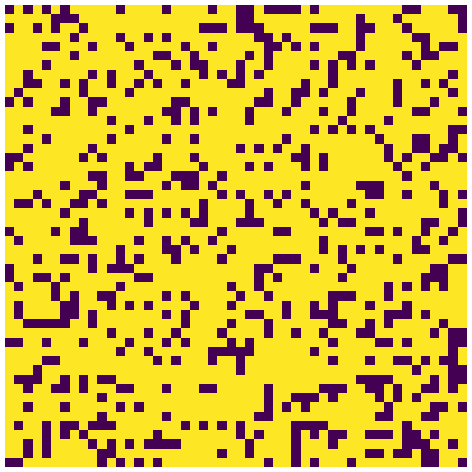

In [32]:
def show_lattice(lattice: NDArray) -> None:
    plt.imshow(lattice, origin="lower")
    plt.axis('off')
    plt.show()

show_lattice(lattice_p)
show_lattice(lattice_n)

Get the energy $E / J = -\sum_{<i,j>} \sigma_i \sigma_j$


To calculate the sum over nearest neighbours, we use convolution. For this, we need to create a convolution kernel. For our case this would be a $3 \times 3$ matrix with the diagonal and antidiagonal values being $0$, and the rest as $1$.

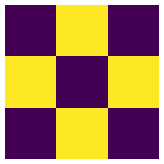

In [34]:
kernel = generate_binary_structure(2, 1)
kernel[1][1] = False

plt.figure(figsize=(2,2))
plt.imshow(kernel)
plt.axis('off')
plt.show()

In [8]:
def get_energy(lattice: NDArray) -> float:
    kernel = generate_binary_structure(2, 1)
    kernel[1][1] = False
    # apply nearest neighbours sum
    arr = -lattice * convolve(lattice, kernel, mode='constant', cval=0)
    return arr.sum()

get_energy(lattice_p)

-2552.0

The metropolis algorithm:
- Takes initial grid of spins, number of time steps, and temperature $\beta J$
- Returns the total spin of all atoms

In [9]:
# N and rng are globals

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nogil=True)
def metropolis(spin_arr:NDArray, iters:int,
               bJ:float, energy:float) -> tuple[NDArray, NDArray]:
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(iters-1)
    net_energy = np.zeros(iters-1)

    for i in range(0, iters-1):
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)

        # pick random indices to flip spins
        spin_i = spin_arr[x,y] # initial spin
        spin_f = spin_i * -1 # proposed spin flip

        # compute energy change
        E_i, E_f = 0, 0

        if x > 0:
            E_i += -spin_i * spin_arr[x-1, y]
            E_f += -spin_f * spin_arr[x-1, y]
        if x < N-1:
            E_i += -spin_i * spin_arr[x+1, y]
            E_f += -spin_f * spin_arr[x+1, y]
        if y > 0:
            E_i += -spin_i * spin_arr[x, y-1]
            E_f += -spin_f * spin_arr[x, y-1]
        if y < N-1:
            E_i += -spin_i * spin_arr[x, y+1]
            E_f += -spin_f * spin_arr[x, y+1]

        # change state with designated probabilities
        dE = E_f - E_i

        if (dE > 0) * (np.random.random() < np.exp(-bJ * dE)):
            spin_arr[x, y] = spin_f
            energy += dE

        elif dE <= 0:
            spin_arr[x,y] = spin_f
            energy += dE

        net_spins[i] = spin_arr.sum()
        net_energy[i] = energy

    return net_spins, net_energy


In [14]:
spins, energies = metropolis(lattice_n, int(1e6), 0.7, get_energy(lattice_n))

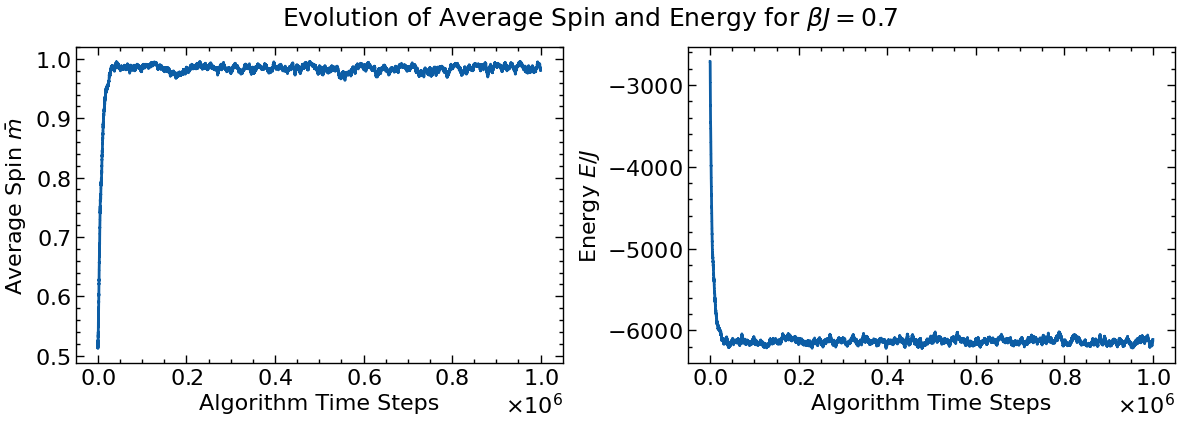

In [15]:
def plot_spin_energy(spins:NDArray, energies:NDArray) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12,4))
    ax = axs[0]
    ax.plot(spins/N**2)
    ax.set_xlabel('Algorithm Time Steps')
    ax.set_ylabel(r'Average Spin $\bar{m}$')
    ax.grid()
    ax = axs[1]
    ax.plot(energies)
    ax.set_xlabel('Algorithm Time Steps')
    ax.set_ylabel(r'Energy $E/J$')
    ax.grid()
    fig.tight_layout()
    fig.suptitle(r'Evolution of Average Spin and Energy for $\beta J=$0.7',
                 y=1.07, size=18)
    plt.show()

plot_spin_energy(spins, energies)

For a higher temperature: decrease $\beta J$

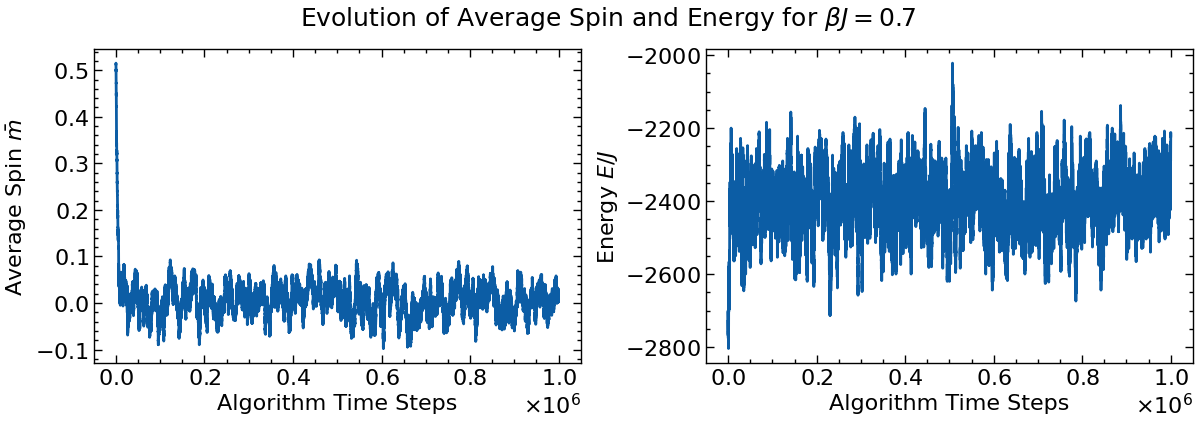

In [16]:
spins, energies = metropolis(lattice_n, int(1e6), 0.2, get_energy(lattice_n))
plot_spin_energy(spins, energies)

We can get stable values of $\bar{m}$ and $E / J$ for various values of $\beta J$. The values will be the average of the last $10^5$ points on the figures above.

In [22]:
from tqdm.auto import tqdm

In [23]:
def get_spin_energy(lattice: NDArray, bJs: NDArray):
    ms = np.zeros(len(bJs))
    E_means = np.zeros(len(bJs))
    E_stds  = np.zeros(len(bJs))
    for i, bJ in tqdm(enumerate(bJs)):
        spins, energies = metropolis(lattice, int(1e6), bJ, get_energy(lattice))
        ms[i] = spins[-int(1e5):].mean() / N**2
        E_means[i] = energies[-int(1e5):].mean()
        E_stds[i]  = energies[-int(1e5):].std()
    return ms, E_means, E_stds

Let's look at $\bar{m}$ as a function of temperature $T = 1/(\beta k) = J / (\beta J k)$

In [21]:
def plot_stable_values(ms_p: NDArray, ms_n: NDArray, bJs: NDArray) -> None:
    plt.figure(figsize=(8,5))
    plt.plot(1/bJs, ms_n, 'o--', label='75% of spins started negative')
    plt.plot(1/bJs, ms_p, 'o--', label='75% of spins started positive')
    plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
    plt.ylabel(r'$\bar{m}$')
    plt.legend(facecolor='white', framealpha=1)
    plt.show()

In [20]:
bJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, bJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, bJs)

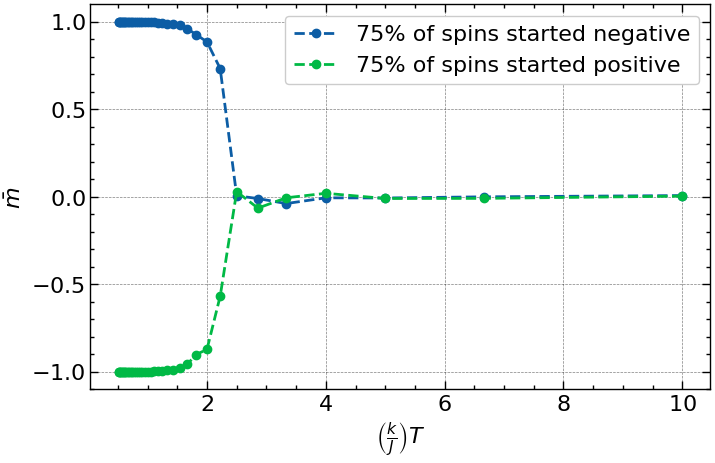

In [24]:
plot_stable_values(ms_p, ms_n, bJs)

The heat capacity can be plotted as a function of temperature using:

\begin{aligned}
C_V & = \sigma^2 / T^2 \\
    & = \left( \left< E^2 \right> - \left< E \right>^2 \cdot \beta^2 k^2 \right) \\
    & = \left( \left< (E/J)^2 \right> - \left< E/J \right>^2 \cdot \beta^2 J^2 k^2 \right) \\
    & = \sigma_{E/J}^2 \cdot (\beta J)^2 k^2
\end{aligned}

In [25]:
def plot_cv(E_stds_p: NDArray, E_stds_n: NDArray, bJs: NDArray) -> None:
    plt.plot(1/bJs, E_stds_n*bJs, label='75% of spins started negative')
    plt.plot(1/bJs, E_stds_p*bJs, label='75% of spins started positive')
    plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
    plt.ylabel(r'$C_V / k^2$')
    plt.legend()
    plt.show()

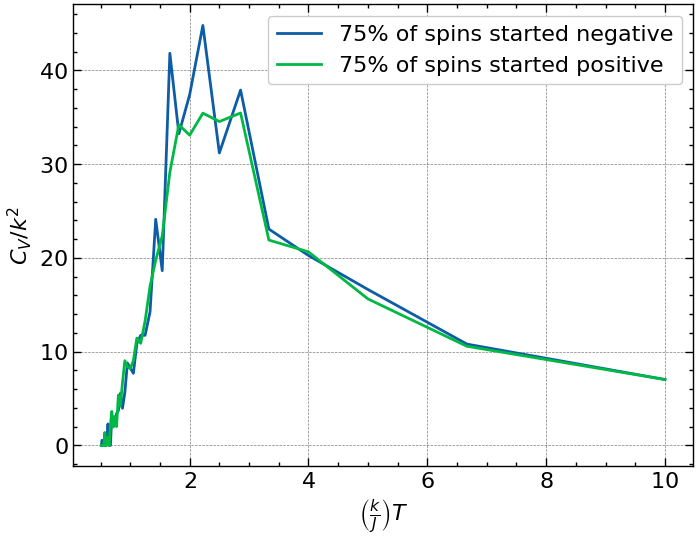

In [26]:
plot_cv(E_stds_p, E_stds_n, bJs)

At the critical temperature (where there's a phase transition), i.e., where we see the peaks in the $C_V$, both of them should look the same. However the Metropolis Algorithm is known to perform poorly at these points of phase transition, which is why the differences in the negative and positive lattices are very different there.